In [1]:
import pandas as pd
import numpy as np
import umap
from sklearn.metrics import pairwise_distances
import altair as alt
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from typing import List

/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
df = pd.read_parquet("../data/rationalized_matrix_amount_20250707_123649.parquet")
df_bool = pd.read_parquet("../data/rationalized_matrix_boolean_20250707_123649.parquet")

In [16]:
grouped_cols = df.groupby(level=[0, 1], axis=1)
df_collapsed = grouped_cols.sum()
# Create normalized dataframe where each row sums to 1
df_normalized = df_collapsed.div(df_collapsed.sum(axis=1), axis=0)
# Drop columns that are all 0 or NaN
df_normalized = df_normalized.fillna(0)
df_normalized = df_normalized.loc[:, (df_normalized != 0).any(axis=0)]
df_normalized = df_normalized.loc[(df_normalized != 0).any(axis=1),:]

grouped_cols = df_bool.groupby(level=[0, 1], axis=1)
df_bool_collapsed = grouped_cols.any()
df_bool_collapsed = df_bool_collapsed.fillna(0).astype(bool)
df_bool_collapsed = df_bool_collapsed.loc[:, df_bool_collapsed.any(axis=0)]  # Remove columns with all False
df_bool_collapsed = df_bool_collapsed.loc[df_bool_collapsed.any(axis=1), :]  # Remove rows with all False

/tmp/ipykernel_248051/1026559341.py:1: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_cols = df.groupby(level=[0, 1], axis=1)
/tmp/ipykernel_248051/1026559341.py:10: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  grouped_cols = df_bool.groupby(level=[0, 1], axis=1)


In [17]:
df_bool_collapsed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1517 entries, #5 to “Jacked” Clover Club
Columns: 303 entries, ('absinthe', 'absinthe') to ('wine', 'white wine')
dtypes: bool(303)
memory usage: 460.7+ KB


In [18]:
df_normalized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1517 entries, #5 to “Jacked” Clover Club
Columns: 303 entries, ('absinthe', 'absinthe') to ('wine', 'white wine')
dtypes: float64(303)
memory usage: 3.5+ MB


In [19]:
distance_matrix_sklearn = pairwise_distances(df_normalized, metric='manhattan')

distance_df_sklearn = pd.DataFrame(
    distance_matrix_sklearn, 
    index=df_normalized.index, 
    columns=df_normalized.index
)

In [22]:
# Function to get recipe information for each cocktail
def get_recipe_string(cocktail_name: str) -> str:
    """Get the recipe as a formatted string for a given cocktail."""
    recipe = df_normalized.loc[cocktail_name, :]
    ingredients = recipe[recipe > 0].sort_values(ascending=False)
    
    if len(ingredients) == 0:
        return "No ingredients found"
    
    # Format ingredients with proportions
    recipe_parts = []
    for ingredient, proportion in ingredients.items():
        # Handle multi-level column names if they exist
        if isinstance(ingredient, tuple):
            ingredient_name = ' - '.join(str(part) for part in ingredient)
        else:
            ingredient_name = str(ingredient)
        recipe_parts.append(f"{ingredient_name}: {proportion:.3f}")
    
    return " | ".join(recipe_parts)

In [24]:
# Create UMAP embedding from the distance matrix
reducer: umap.UMAP = umap.UMAP(
    n_neighbors=15, 
    n_components=2, 
    metric='precomputed', 
    random_state=42
)
embedding: np.ndarray = reducer.fit_transform(distance_matrix_sklearn)

# Create a DataFrame with the embedding coordinates and names
embedding_df: pd.DataFrame = pd.DataFrame(
    embedding,
    columns=['UMAP1', 'UMAP2'],
    index=distance_df_sklearn.index
)
embedding_df['name'] = embedding_df.index

# Add recipe strings to the embedding dataframe
embedding_df['recipe'] = embedding_df['name'].apply(get_recipe_string)

# Create the Altair chart
chart: alt.Chart = alt.Chart(embedding_df.reset_index()).mark_circle(
    size=100, 
    opacity=0.7
).encode(
    x=alt.X('UMAP1:Q', title='UMAP Dimension 1'),
    y=alt.Y('UMAP2:Q', title='UMAP Dimension 2'),
    tooltip=['name:N', 'recipe:N'],
    color=alt.value('steelblue'),
    stroke=alt.value('white'),
    strokeWidth=alt.value(1)
).properties(
    width=600,
    height=500,
    title='UMAP Embedding of Cocktail Recipes By Volumetric Edit Distance'
).interactive()

chart.show()

/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


alt.Chart(...)

In [25]:
distance_matrix_jaccard = pairwise_distances(df_bool_collapsed.astype(int).values, metric='jaccard')

# Create UMAP embedding using Jaccard distance
reducer_jaccard: umap.UMAP = umap.UMAP(
    n_neighbors=15, 
    n_components=2, 
    metric='precomputed', 
    random_state=42
)
embedding_jaccard: np.ndarray = reducer_jaccard.fit_transform(distance_matrix_jaccard)

# Create embedding DataFrame for Jaccard
embedding_jaccard_df: pd.DataFrame = pd.DataFrame(
    embedding_jaccard,
    columns=['UMAP1', 'UMAP2'],
    index=df_bool_collapsed.index
)
embedding_jaccard_df['name'] = embedding_jaccard_df.index
embedding_jaccard_df['ingredients'] = embedding_jaccard_df['name'].apply(get_recipe_string)

# Create the Altair chart for Jaccard distance
chart_jaccard: alt.Chart = alt.Chart(embedding_jaccard_df.reset_index()).mark_circle(
    size=100, 
    opacity=0.7
).encode(
    x=alt.X('UMAP1:Q', title='UMAP Dimension 1'),
    y=alt.Y('UMAP2:Q', title='UMAP Dimension 2'),
    tooltip=['name:N', 'ingredients:N'],
    color=alt.value('darkgreen'),
    stroke=alt.value('white'),
    strokeWidth=alt.value(1)
).properties(
    width=600,
    height=500,
    title='UMAP Embedding of Cocktail Recipes (Binary Data - Jaccard Distance)'
).interactive()

chart_jaccard.show()

/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/sklearn/metrics/pairwise.py:2463: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


alt.Chart(...)

In [26]:
distance_matrix_hamming = pairwise_distances(df_bool_collapsed.astype(int), metric='hamming')

# Create UMAP embedding using precomputed Hamming distances
reducer_bool: umap.UMAP = umap.UMAP(
    n_neighbors=15, 
    n_components=2, 
    metric='precomputed', 
    random_state=42
)
embedding_bool: np.ndarray = reducer_bool.fit_transform(distance_matrix_hamming)

# Create embedding DataFrame
embedding_bool_df: pd.DataFrame = pd.DataFrame(
    embedding_bool,
    columns=['UMAP1', 'UMAP2'],
    index=df_bool_collapsed.index
)
embedding_bool_df['name'] = embedding_bool_df.index

# Add ingredient list for each cocktail
def get_boolean_recipe_string(cocktail_name: str) -> str:
    """Get the ingredients as a formatted string for a given cocktail."""
    recipe = df_bool_collapsed.loc[cocktail_name, :]
    ingredients = recipe[recipe == True]
    
    if len(ingredients) == 0:
        return "No ingredients found"
    
    # Format ingredients
    ingredient_names = []
    for ingredient in ingredients.index:
        # Handle multi-level column names if they exist
        if isinstance(ingredient, tuple):
            ingredient_name = ' - '.join(str(part) for part in ingredient)
        else:
            ingredient_name = str(ingredient)
        ingredient_names.append(ingredient_name)
    
    return " | ".join(ingredient_names)

# Add ingredient strings to the embedding dataframe
embedding_bool_df['ingredients'] = embedding_bool_df['name'].apply(get_boolean_recipe_string)

# Create the Altair chart for boolean data
chart_bool: alt.Chart = alt.Chart(embedding_bool_df.reset_index()).mark_circle(
    size=100, 
    opacity=0.7
).encode(
    x=alt.X('UMAP1:Q', title='UMAP Dimension 1'),
    y=alt.Y('UMAP2:Q', title='UMAP Dimension 2'),
    tooltip=['name:N', 'ingredients:N'],
    color=alt.value('darkred'),
    stroke=alt.value('white'),
    strokeWidth=alt.value(1)
).properties(
    width=600,
    height=500,
    title='UMAP Embedding of Cocktail Recipes (Binary Data - Hamming Distance)'
).interactive()

chart_bool.show()


/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1865: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


alt.Chart(...)

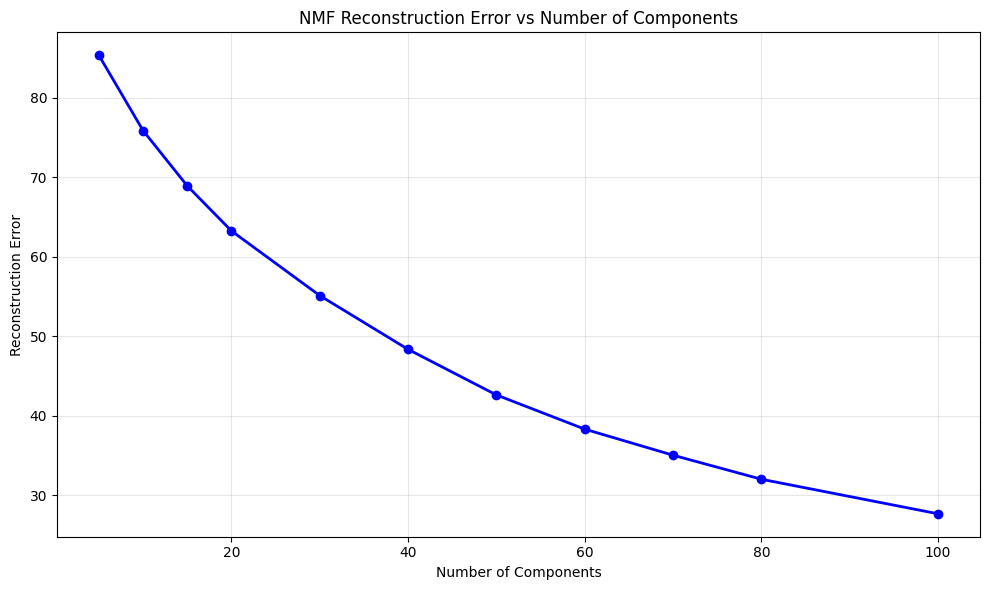

In [27]:
# Plot reconstruction error for different numbers of components
n_components_range = [5, 10, 15, 20, 30, 40, 50, 60, 70, 80, 100]
reconstruction_errors = []

for n_comp in n_components_range:
    nmf = NMF(
        n_components=n_comp,
        beta_loss="kullback-leibler",
        solver="mu",
        l1_ratio=0.0,
        random_state=42,
    )
    nmf.fit(df_normalized)
    reconstruction_errors.append(nmf.reconstruction_err_)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, reconstruction_errors, "bo-", linewidth=2, markersize=6)
plt.xlabel("Number of Components")
plt.ylabel("Reconstruction Error")
plt.title("NMF Reconstruction Error vs Number of Components")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [28]:
nmf = NMF(n_components=60, beta_loss='kullback-leibler', solver='mu', l1_ratio=0.0)  
W = nmf.fit_transform(df_normalized)        # recipe factors
H = nmf.components_            # ingredient factors

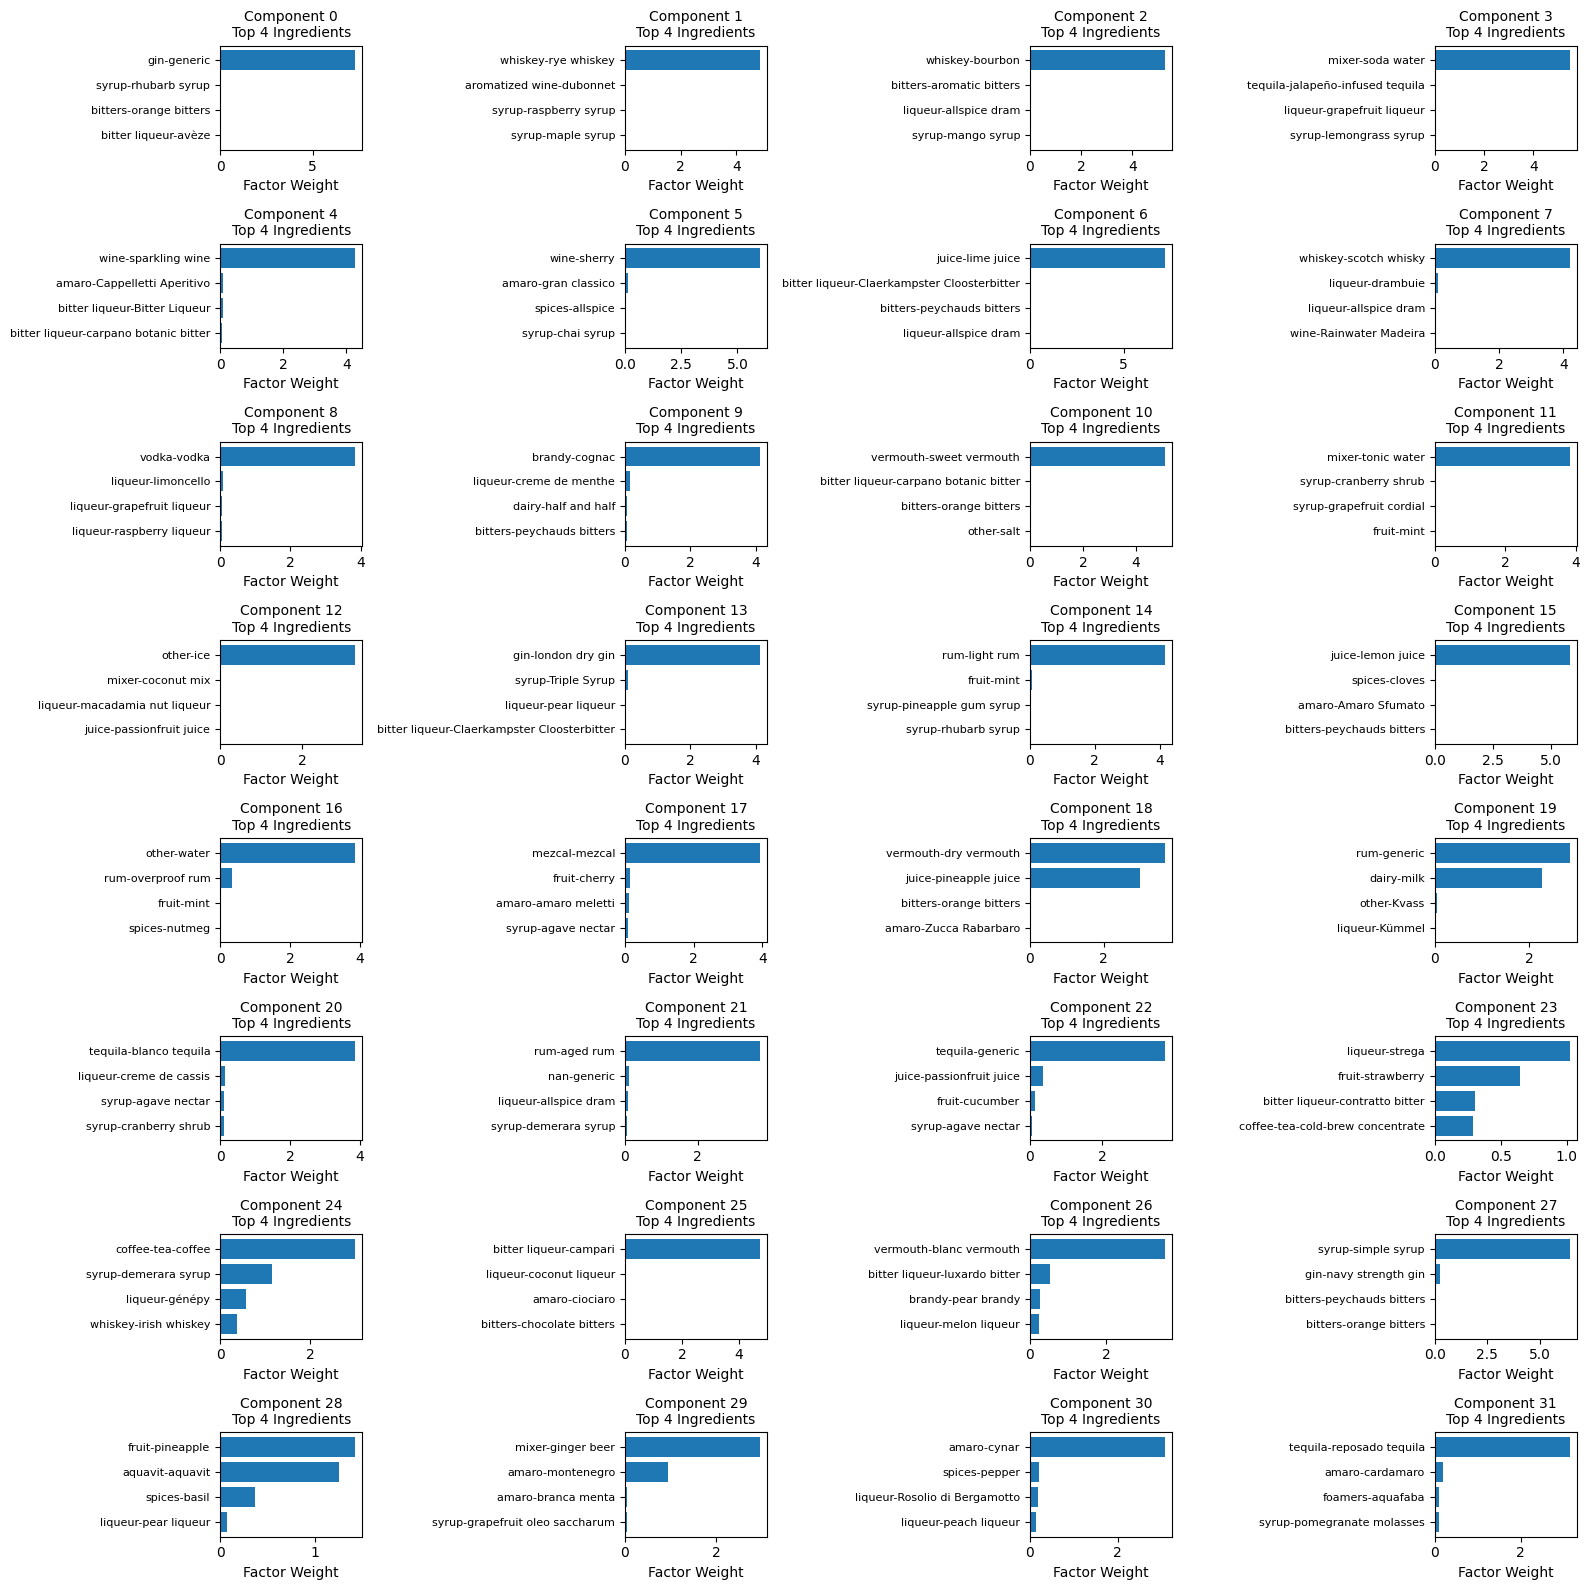

In [29]:
def visualize_ingredient_factors(
    H: np.ndarray,
    ingredient_names: list[str],
    n_top: int = 10,
    n_components_show: int = 8,
) -> None:
    """
    Visualize the top ingredients for each NMF component.

    Args:
        H: Ingredient factors matrix (n_components x n_ingredients)
        ingredient_names: List of ingredient names
        n_top: Number of top ingredients to show per component
        n_components_show: Number of components to visualize
    """
    fig, axes = plt.subplots(n_components_show//4, 4, figsize=(16, 16))
    axes = axes.flatten()

    for i in range(min(n_components_show, H.shape[0])):
        # Get top ingredients for this component
        top_indices = np.argsort(H[i])[-n_top:][::-1]
        top_values = H[i][top_indices]
        top_ingredients = [ingredient_names[idx] for idx in top_indices]

        # Clean ingredient names (handle tuples)
        clean_names = []
        for ing in top_ingredients:
            if isinstance(ing, tuple):
                clean_names.append(f"{ing[0]}-{ing[1]}")
            else:
                clean_names.append(str(ing))

        # Create bar plot
        axes[i].barh(range(len(clean_names)), top_values)
        axes[i].set_yticks(range(len(clean_names)))
        axes[i].set_yticklabels(clean_names, fontsize=8)
        axes[i].set_xlabel("Factor Weight")
        axes[i].set_title(f"Component {i}\nTop {n_top} Ingredients", fontsize=10)
        axes[i].invert_yaxis()

    plt.tight_layout()
    plt.show()


# Visualize ingredient factors
ingredient_names = list(df_normalized.columns)
visualize_ingredient_factors(H, ingredient_names, n_top=4, n_components_show=32)


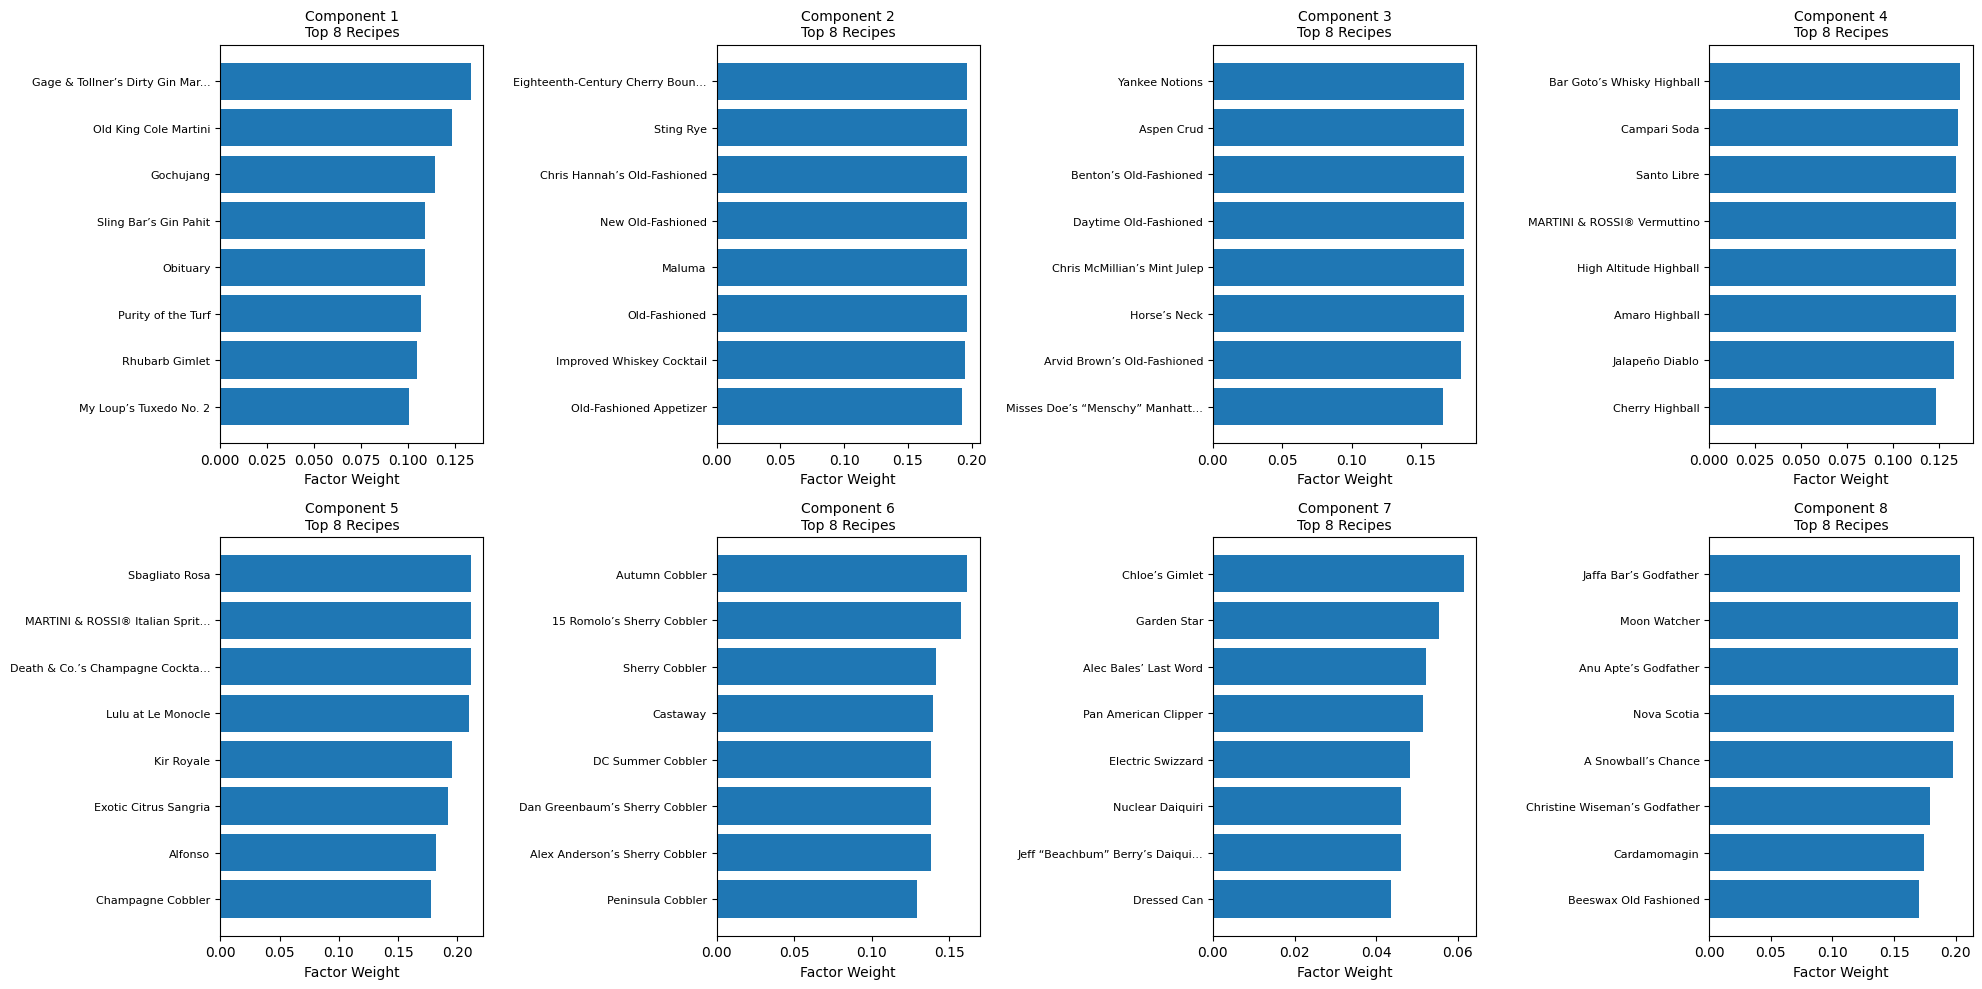

In [30]:
def visualize_recipe_factors(W: np.ndarray, recipe_names: List[str], n_top: int = 10, 
                             n_components_show: int = 8) -> None:
    """
    Visualize the top recipes for each NMF component.
    
    Args:
        W: Recipe factors matrix (n_recipes x n_components)
        recipe_names: List of recipe names
        n_top: Number of top recipes to show per component
        n_components_show: Number of components to visualize
    """
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    axes = axes.flatten()
    
    for i in range(min(n_components_show, W.shape[1])):
        # Get top recipes for this component
        top_indices = np.argsort(W[:, i])[-n_top:][::-1]
        top_values = W[top_indices, i]
        top_recipes = [recipe_names[idx] for idx in top_indices]
        
        # Truncate long recipe names
        clean_names = [name[:30] + '...' if len(name) > 30 else name for name in top_recipes]
        
        # Create bar plot
        axes[i].barh(range(len(clean_names)), top_values)
        axes[i].set_yticks(range(len(clean_names)))
        axes[i].set_yticklabels(clean_names, fontsize=8)
        axes[i].set_xlabel('Factor Weight')
        axes[i].set_title(f'Component {i+1}\nTop {n_top} Recipes', fontsize=10)
        axes[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Visualize recipe factors
recipe_names = list(df_normalized.index)
visualize_recipe_factors(W, recipe_names, n_top=8, n_components_show=8)


In [31]:
# Create 2D UMAP visualization of recipe clusters based on NMF factors
def create_nmf_umap_visualization(W: np.ndarray, recipe_names: List[str]) -> pd.DataFrame:
    """
    Create UMAP embedding of recipes based on NMF factors.
    
    Args:
        W: Recipe factors matrix (n_recipes x n_components)
        recipe_names: List of recipe names
        
    Returns:
        DataFrame with UMAP coordinates and cluster assignments
    """
    # Create UMAP embedding from NMF factors
    reducer = umap.UMAP(
        n_neighbors=15, 
        n_components=2, 
        metric='cosine',  # Cosine distance works well for factor matrices
        random_state=42
    )
    embedding = reducer.fit_transform(W)
    
    # Assign each recipe to its dominant component
    dominant_components = np.argmax(W, axis=1)
    
    # Create DataFrame
    embedding_df = pd.DataFrame({
        'UMAP1': embedding[:, 0],
        'UMAP2': embedding[:, 1],
        'recipe_name': recipe_names,
        'dominant_component': dominant_components,
        'max_factor_weight': np.max(W, axis=1)
    })
    
    return embedding_df

# Create the embedding
nmf_embedding_df = create_nmf_umap_visualization(W, recipe_names)
nmf_embedding_df['ingredients'] = nmf_embedding_df['recipe_name'].apply(get_recipe_string)
# Create interactive plot with Altair
chart = alt.Chart(nmf_embedding_df).mark_circle().add_params(
    alt.selection_point()
).encode(
    x=alt.X('UMAP1:Q', title='UMAP Dimension 1'),
    y=alt.Y('UMAP2:Q', title='UMAP Dimension 2'),
    color=alt.Color('dominant_component:N', 
                   title='Dominant Component',
                   scale=alt.Scale(scheme='viridis')),
    tooltip=['recipe_name:N', 'dominant_component:N', 'ingredients:N']
).properties(
    width=800,
    height=600,
    title='NMF Recipe Clusters - UMAP Visualization'
).interactive()

# Display the chart
chart.show()
print(f"Created UMAP visualization with {len(nmf_embedding_df)} recipes")
print(f"Number of unique dominant components: {nmf_embedding_df['dominant_component'].nunique()}")


/home/kurtt/miniforge3/envs/py313/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


alt.Chart(...)

Created UMAP visualization with 1517 recipes
Number of unique dominant components: 60
